Import Required Libraries

In [6]:
import re
import string
import shutil
import numpy as np
import pandas as pd
from keras import optimizers
from keras.models import load_model
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from numpy import array, argmax, random, take
from keras.preprocessing.text import Tokenizer
from nltk.translate.bleu_score import sentence_bleu
from sklearn.model_selection import train_test_split
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Dense, LSTM, Embedding, RepeatVector

import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

Read Data

In [7]:
# function to read raw text file 
def read_text(filename): 
  # open the file 
  file = open(filename, mode='rt', encoding='utf-8') 
  # read all text 
  text = file.read() 
  file.close() 
  return text

In [8]:
# split a text into sentences 
def to_lines(text): 
  sents = text.strip().split('\n') 
  sents = [i.split('\t')[:2] for i in sents] 
  return sents

In [9]:
data = read_text("fra.txt") 
fre_eng = to_lines(data) 
fre_eng = array(fre_eng)
fre_eng

array([['Go.', 'Va !'],
       ['Go.', 'Marche.'],
       ['Go.', 'En route !'],
       ...,
       ['It should be like this.', 'Ça devrait être ainsi.'],
       ['It smells like ammonia.', "Ça a une odeur d'ammoniac."],
       ['It sounds like a dream.', 'Ça ressemble à un rêve.']],
      dtype='<U72')

In [10]:
fre_eng = fre_eng[:50000,:]

Text Pre-Processing

In [11]:
# Remove punctuation
fre_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in fre_eng[:,0]]
fre_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in fre_eng[:,1]]

fre_eng

array([['Go', 'Va '],
       ['Go', 'Marche'],
       ['Go', 'En route '],
       ...,
       ['I need to go to sleep', 'Je dois aller dormir'],
       ['I need to keep moving', 'Je dois continuer à avancer'],
       ['I need to make a copy', 'Je dois faire une copie']], dtype='<U72')

In [12]:
# convert text to lowercase
for i in range(len(fre_eng)):
  fre_eng[i,0] = fre_eng[i,0].lower()
  fre_eng[i,1] = fre_eng[i,1].lower()

fre_eng

array([['go', 'va '],
       ['go', 'marche'],
       ['go', 'en route '],
       ...,
       ['i need to go to sleep', 'je dois aller dormir'],
       ['i need to keep moving', 'je dois continuer à avancer'],
       ['i need to make a copy', 'je dois faire une copie']], dtype='<U72')

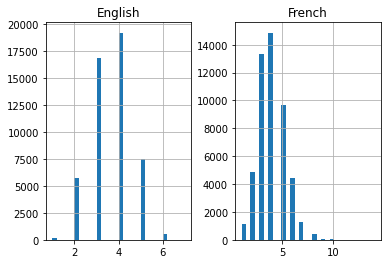

In [13]:
# empty lists
eng_l = []
fre_l = []

# populate the lists with sentence lengths
for i in fre_eng[:,0]:
  eng_l.append(len(i.split()))

for i in fre_eng[:,1]:
  fre_l.append(len(i.split()))

length_df = pd.DataFrame({'English':eng_l, 'French':fre_l})

length_df.hist(bins = 30)
plt.show()

In [14]:
# function to build a tokenizer
def tokenization(lines):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(lines)
  return tokenizer

In [15]:
# prepare english tokenizer
eng_tokenizer = tokenization(fre_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 6142


In [16]:
# prepare French tokenizer
fre_tokenizer = tokenization(fre_eng[:, 1])
fre_vocab_size = len(fre_tokenizer.word_index) + 1

fre_length = 8
print('French Vocabulary Size: %d' % fre_vocab_size)

French Vocabulary Size: 14167


In [17]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
  # integer encode sequences
  seq = tokenizer.texts_to_sequences(lines)
  # pad sequences with 0 values
  seq = pad_sequences(seq, maxlen=length, padding='post')
  return seq

In [18]:
# split data into train and test set
train, test = train_test_split(fre_eng, test_size=0.2, random_state = 12)

In [19]:
# prepare training data
trainX = encode_sequences(fre_tokenizer, fre_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

# prepare validation data
testX = encode_sequences(fre_tokenizer, fre_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

Model Building

In [20]:
# build NMT model
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
  model = Sequential()
  model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
  model.add(LSTM(units))
  model.add(RepeatVector(out_timesteps))
  model.add(LSTM(units, return_sequences=True))
  model.add(Dense(out_vocab, activation='softmax'))
  return model

In [21]:
# model compilation
model = define_model(fre_vocab_size, eng_vocab_size, fre_length, eng_length, 512)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 8, 512)            7253504   
                                                                 
 lstm (LSTM)                 (None, 512)               2099200   
                                                                 
 repeat_vector (RepeatVector  (None, 8, 512)           0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 8, 512)            2099200   
                                                                 
 dense (Dense)               (None, 8, 6142)           3150846   
                                                                 
Total params: 14,602,750
Trainable params: 14,602,750
Non-trainable params: 0
____________________________________________

In [22]:
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [23]:
filename = 'model.eng_fre'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), epochs=30, batch_size=512, validation_split = 0.2,callbacks=[checkpoint], verbose=1)

Epoch 1/30
62/63 [============================>.] - ETA: 0s - loss: 3.4016
Epoch 1: val_loss improved from inf to 2.83769, saving model to model.eng_fre


63/63 [==============================] - 29s 307ms/step - loss: 3.3973 - val_loss: 2.8377
Epoch 2/30
62/63 [============================>.] - ETA: 0s - loss: 2.7287
Epoch 2: val_loss improved from 2.83769 to 2.70021, saving model to model.eng_fre


63/63 [==============================] - 17s 269ms/step - loss: 2.7282 - val_loss: 2.7002
Epoch 3/30
62/63 [============================>.] - ETA: 0s - loss: 2.5965
Epoch 3: val_loss improved from 2.70021 to 2.56398, saving model to model.eng_fre


63/63 [==============================] - 17s 268ms/step - loss: 2.5951 - val_loss: 2.5640
Epoch 4/30
62/63 [============================>.] - ETA: 0s - loss: 2.4151
Epoch 4: val_loss improved from 2.56398 to 2.42263, saving model to model.eng_fre


63/63 [==============================] - 17s 277ms/step - loss: 2.4146 - val_loss: 2.4226
Epoch 5/30
62/63 [============================>.] - ETA: 0s - loss: 2.2570
Epoch 5: val_loss improved from 2.42263 to 2.29325, saving model to model.eng_fre


63/63 [==============================] - 17s 270ms/step - loss: 2.2567 - val_loss: 2.2933
Epoch 6/30
62/63 [============================>.] - ETA: 0s - loss: 2.1186
Epoch 6: val_loss improved from 2.29325 to 2.19151, saving model to model.eng_fre


63/63 [==============================] - 17s 272ms/step - loss: 2.1182 - val_loss: 2.1915
Epoch 7/30
62/63 [============================>.] - ETA: 0s - loss: 1.9816
Epoch 7: val_loss improved from 2.19151 to 2.08892, saving model to model.eng_fre


63/63 [==============================] - 17s 271ms/step - loss: 1.9816 - val_loss: 2.0889
Epoch 8/30
62/63 [============================>.] - ETA: 0s - loss: 1.8605
Epoch 8: val_loss improved from 2.08892 to 2.01044, saving model to model.eng_fre


63/63 [==============================] - 17s 275ms/step - loss: 1.8600 - val_loss: 2.0104
Epoch 9/30
62/63 [============================>.] - ETA: 0s - loss: 1.7478
Epoch 9: val_loss improved from 2.01044 to 1.93289, saving model to model.eng_fre


63/63 [==============================] - 17s 275ms/step - loss: 1.7482 - val_loss: 1.9329
Epoch 10/30
62/63 [============================>.] - ETA: 0s - loss: 1.6470
Epoch 10: val_loss improved from 1.93289 to 1.86583, saving model to model.eng_fre


63/63 [==============================] - 17s 270ms/step - loss: 1.6479 - val_loss: 1.8658
Epoch 11/30
62/63 [============================>.] - ETA: 0s - loss: 1.5502
Epoch 11: val_loss improved from 1.86583 to 1.81436, saving model to model.eng_fre


63/63 [==============================] - 17s 271ms/step - loss: 1.5504 - val_loss: 1.8144
Epoch 12/30
62/63 [============================>.] - ETA: 0s - loss: 1.4625
Epoch 12: val_loss improved from 1.81436 to 1.75848, saving model to model.eng_fre


63/63 [==============================] - 17s 274ms/step - loss: 1.4629 - val_loss: 1.7585
Epoch 13/30
62/63 [============================>.] - ETA: 0s - loss: 1.3780
Epoch 13: val_loss improved from 1.75848 to 1.71447, saving model to model.eng_fre


63/63 [==============================] - 17s 276ms/step - loss: 1.3783 - val_loss: 1.7145
Epoch 14/30
62/63 [============================>.] - ETA: 0s - loss: 1.2972
Epoch 14: val_loss improved from 1.71447 to 1.70886, saving model to model.eng_fre


63/63 [==============================] - 17s 272ms/step - loss: 1.2969 - val_loss: 1.7089
Epoch 15/30
62/63 [============================>.] - ETA: 0s - loss: 1.2206
Epoch 15: val_loss improved from 1.70886 to 1.66650, saving model to model.eng_fre


63/63 [==============================] - 18s 285ms/step - loss: 1.2213 - val_loss: 1.6665
Epoch 16/30
62/63 [============================>.] - ETA: 0s - loss: 1.1483
Epoch 16: val_loss improved from 1.66650 to 1.59829, saving model to model.eng_fre


63/63 [==============================] - 17s 275ms/step - loss: 1.1480 - val_loss: 1.5983
Epoch 17/30
62/63 [============================>.] - ETA: 0s - loss: 1.0774
Epoch 17: val_loss improved from 1.59829 to 1.56780, saving model to model.eng_fre


63/63 [==============================] - 17s 271ms/step - loss: 1.0771 - val_loss: 1.5678
Epoch 18/30
62/63 [============================>.] - ETA: 0s - loss: 1.0095
Epoch 18: val_loss improved from 1.56780 to 1.54480, saving model to model.eng_fre


63/63 [==============================] - 17s 275ms/step - loss: 1.0104 - val_loss: 1.5448
Epoch 19/30
62/63 [============================>.] - ETA: 0s - loss: 0.9456
Epoch 19: val_loss improved from 1.54480 to 1.52063, saving model to model.eng_fre


63/63 [==============================] - 17s 275ms/step - loss: 0.9457 - val_loss: 1.5206
Epoch 20/30
62/63 [============================>.] - ETA: 0s - loss: 0.8825
Epoch 20: val_loss improved from 1.52063 to 1.50407, saving model to model.eng_fre


63/63 [==============================] - 17s 278ms/step - loss: 0.8827 - val_loss: 1.5041
Epoch 21/30
62/63 [============================>.] - ETA: 0s - loss: 0.8255
Epoch 21: val_loss improved from 1.50407 to 1.47525, saving model to model.eng_fre


63/63 [==============================] - 17s 275ms/step - loss: 0.8255 - val_loss: 1.4753
Epoch 22/30
62/63 [============================>.] - ETA: 0s - loss: 0.7662
Epoch 22: val_loss improved from 1.47525 to 1.44222, saving model to model.eng_fre


63/63 [==============================] - 17s 276ms/step - loss: 0.7664 - val_loss: 1.4422
Epoch 23/30
62/63 [============================>.] - ETA: 0s - loss: 0.7141
Epoch 23: val_loss did not improve from 1.44222
63/63 [==============================] - 4s 67ms/step - loss: 0.7143 - val_loss: 1.4430
Epoch 24/30
62/63 [============================>.] - ETA: 0s - loss: 0.6625
Epoch 24: val_loss improved from 1.44222 to 1.41532, saving model to model.eng_fre


63/63 [==============================] - 17s 274ms/step - loss: 0.6626 - val_loss: 1.4153
Epoch 25/30
62/63 [============================>.] - ETA: 0s - loss: 0.6131
Epoch 25: val_loss improved from 1.41532 to 1.40447, saving model to model.eng_fre


63/63 [==============================] - 17s 274ms/step - loss: 0.6132 - val_loss: 1.4045
Epoch 26/30
62/63 [============================>.] - ETA: 0s - loss: 0.5691
Epoch 26: val_loss improved from 1.40447 to 1.38689, saving model to model.eng_fre


63/63 [==============================] - 17s 270ms/step - loss: 0.5694 - val_loss: 1.3869
Epoch 27/30
62/63 [============================>.] - ETA: 0s - loss: 0.5247
Epoch 27: val_loss improved from 1.38689 to 1.37878, saving model to model.eng_fre


63/63 [==============================] - 17s 273ms/step - loss: 0.5246 - val_loss: 1.3788
Epoch 28/30
62/63 [============================>.] - ETA: 0s - loss: 0.4866
Epoch 28: val_loss improved from 1.37878 to 1.36196, saving model to model.eng_fre


63/63 [==============================] - 17s 273ms/step - loss: 0.4867 - val_loss: 1.3620
Epoch 29/30
62/63 [============================>.] - ETA: 0s - loss: 0.4458
Epoch 29: val_loss improved from 1.36196 to 1.36082, saving model to model.eng_fre


63/63 [==============================] - 18s 286ms/step - loss: 0.4464 - val_loss: 1.3608
Epoch 30/30
62/63 [============================>.] - ETA: 0s - loss: 0.4116
Epoch 30: val_loss did not improve from 1.36082
63/63 [==============================] - 4s 67ms/step - loss: 0.4122 - val_loss: 1.3752


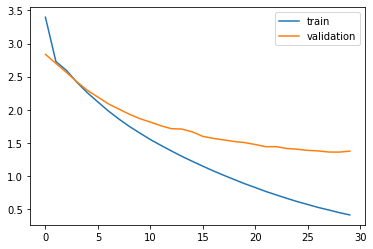

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [25]:
model = load_model('model.eng_fre')
predict = model.predict(testX.reshape((testX.shape[0],testX.shape[1])))
preds = np.argmax(predict,axis=1)

313/313 [==============================] - 3s 5ms/step


In [26]:
def get_word(n, tokenizer):
  for word, index in tokenizer.word_index.items():
    if index == n:
      return word
  return None

In [27]:
preds_text = []
for i in preds[:20]:
  temp = []
  for j in range(len(i)):
    t = get_word(i[j], eng_tokenizer)
    if j > 0:
      if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
        temp.append('')
      else:
        temp.append(t)
    else:
      if(t == None):
        temp.append('')
      else:
        temp.append(t) 

  preds_text.append(' '.join(temp))